In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
engine.execute(text('SELECT * FROM measurement LIMIT 5')).fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year

datetime.date(2016, 8, 23)

In [13]:
# Define your selection
sel = [Measurement.date, Measurement.prcp]

# Get the most recent data point
recent_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = dt.datetime.strptime(recent_data_point[0], '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores for the last 12 months
precipitation_data = session.query(*sel).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the column names
df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
# Sort the DataFrame by date
df.sort_values(by='date', inplace=True)

# Drop any rows with missing data
df.dropna(how='any', inplace=True)

df


,date,precipitation
0,2016-08-23,0.00
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
1881,2016-08-23,0.70
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


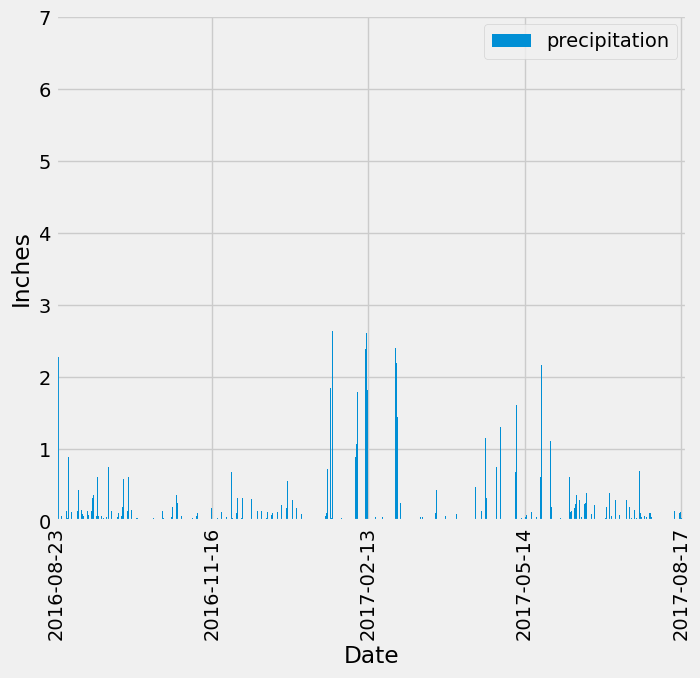

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
sel = [Measurement.date, Measurement.prcp]
# Starting from the most recent data point in the database. 
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
one_year = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
one_year_ago = session.query(*sel).filter(Measurement.date >= one_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df= pd.DataFrame(one_year_ago, columns = ['date', 'precipitation'])
# Sort the dataframe by date
df.set_index('date', inplace=True)
df.sort_values(by='date', inplace=True)
df.dropna(how='any', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar(figsize=(7,7),width=0.5)
plt.tight_layout()
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = df["precipitation"].describe()
summary_df = pd.DataFrame(summary)
summary_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# Design a query to calculate the total number of stations in the dataset

session.query(Measurement.station).distinct().count()

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stat = session.query(Measurement.station, func.count(Measurement.station)).\
       group_by(Measurement.station).\
       order_by(func.count(Measurement.station).desc()).all()
stat

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_stat = [func.min(Measurement.tobs),
               func.max(Measurement.tobs),
               func.avg(Measurement.tobs)]

station_id = stat[0][0]

stat_avg = session.query(*station_stat).filter(Measurement.station == station_id).all()
stat_avg

[(54.0, 85.0, 71.66378066378067)]

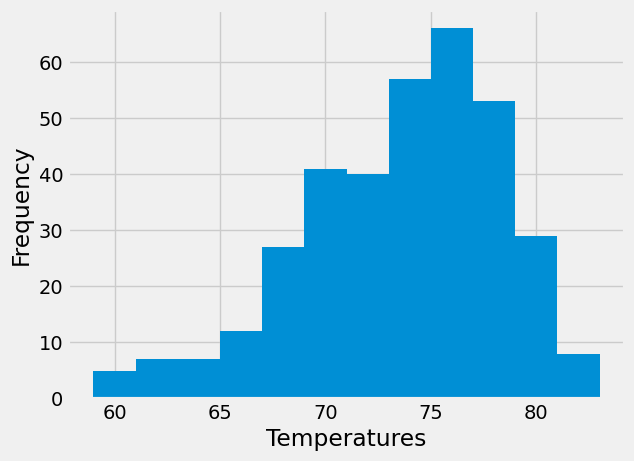

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_stat = session.query(Measurement.tobs).\
                        filter(Measurement.station == station_id).\
                        filter(Measurement.date >= one_year).all()

temperatures = [temp[0] for temp in station_stat]
plt.hist(temperatures, bins=12, label="tobs")
plt.xlabel("Temperatures")
plt.ylabel("Frequency")
plt.show()


# Close Session

In [21]:
# Close Session
session.close()